<a href="https://colab.research.google.com/github/manas1999/BootCamp-API/blob/main/Siamese_and_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
import wave
from scipy.signal import butter, sosfilt, sosfreqz,freqz
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft
import librosa
import numpy as np
import pandas as pd
from librosa import display
import tensorflow as tf
from keras.layers import Input
from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPool1D
from keras.models import Sequential
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot
from keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import os, sys
import tensorflow as tf
from keras.utils.vis_utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
temp = pd.read_csv('/content/drive/MyDrive/Intern/Data Heart Beat/Atraining_normal_seg.csv')
temp.head()

,Unnamed: 0,S1,S2,S1.1,S2.1,S1.2,S2.2,S1.3,S2.3,S1.4,...,S2.14,S1.15,S2.15,S1.16,S2.16,S1.17,S2.17,S1.18,S2.18,Unnamed: 39
0,201102081321.aif,10021.0,20759,35075,47244,62992,73729,88761,101646,115246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201102260502.aif,NaN,11526,27941,42197,58163,71278,88955,102641,122028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201103090635.aif,5366.0,17632,31432,44464,59030,71296,86629,99661,116527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201103140132.aif,16358.0,29272,89539,105036,128282,142057,170469,183383,207490,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201103140822.aif,3444.0,18080,44770,58545,84374,98149,123977,134309,157555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def butter_bandpass(data,lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        y = sosfilt(sos, data)
        return y

In [5]:
wav2 = wave.open('/content/drive/MyDrive/Intern/Data Heart Beat/total data/sample_300.wav')
data, rate = librosa.load('/content/drive/MyDrive/Intern/Data Heart Beat/total data/sample_300.wav' )

##filtering Process 
fs = wav2.getframerate() ######################################### >>>>>>>>>>>>>>>>>>>>>>MISTAKE
T = wav2.getnframes()/wav2.getframerate()
N = nsamples = int(T * fs)
t = np.linspace(0, T, nsamples, endpoint=False)


lowcut = 20.0
highcut = 250.0
# create training data
data_x = []
data_y = []
for j in range(temp.shape[0]):
   data, sampling_rate = librosa.load('/content/drive/MyDrive/Intern/Data Heart Beat/Atraining_normal/'+ temp.iloc[j, 0].split('.')[0] +'.wav', sr=44100 )
   data = butter_bandpass(data,lowcut,highcut,fs)
   for i in range(1, temp.shape[1] - 1):
     try: 
       temp_data = data[int(temp.iloc[j, i]):int(temp.iloc[j, i+1])]
       temp_label = temp.iloc[:, i].name.split('.')[0]
 
       data_x.append(temp_data)
       data_y.append(temp_label)
     except:
       pass

In [6]:
from keras.preprocessing.sequence import pad_sequences

data_x = pad_sequences(data_x, maxlen=20000, dtype='float', padding='post', truncating='post', value=0.)

data_x = data_x / np.max(data_x)

In [7]:
data_x = data_x[:,:,np.newaxis]
data_y = pd.Series(data_y)
data_y.value_counts()

data_y = data_y.map({'S1':0, 'S2':1}).values

In [8]:
print(data_x.shape)

(369, 20000, 1)


In [9]:
Set_X1 = []
Set_X2 = []
Set_Y = []
for i in range(int(data_x.shape[0]/5)):
  for j in range(int(data_x.shape[0]/5)):
    if(i!= j):
      Set_X1.append(data_x[i])
      Set_X2.append(data_x[j])
      if(data_y[i] == data_y[j] and data_y[i] == 1):
        Set_Y.append(1)
      else :
        Set_Y.append(0)
  

In [10]:
print(np.shape(Set_Y))
input_shape=data_x.shape[1:]
print(input_shape)


(5256,)
(20000, 1)


**Siamese Network**

In [11]:
# Train autoencoder and save encoder model and encodings
def train_color_encoder(X1, X2, set_Y) :



    # Color Encoder
    input_layer = Input(data_x.shape[1:])
    layer1 = Conv1D(filters=50,kernel_size = 10, activation='relu', padding='same')(input_layer)
    layer2 = MaxPool1D(strides=8, padding='same')(layer1)
    layer3 = Conv1D(filters=50,kernel_size = 10, activation='relu', padding='same')(layer2)
    layer4 = MaxPool1D(strides=8, padding='same')(layer3)
    layer5 = Flatten()(layer4)
    embeddings = Dense(256, activation=None)(layer5)
    norm_embeddings = tf.nn.l2_normalize(embeddings, axis=-1)


    # Create model
    model = Model(inputs=input_layer, outputs=norm_embeddings)


    # Create siamese model
    input1 = Input(data_x.shape[1:])
    input2 = Input(data_x.shape[1:])

    # Create left and right twin models
    left_model = model(input1)
    right_model = model(input2)


    # Dot product layer
    dot_product = dot([left_model, right_model], axes=1, normalize=False)

    siamese_model = Model(inputs=[input1, input2], outputs=dot_product)

    # Model summary 
    print(siamese_model.summary())

    # Compile model    
    siamese_model.compile(optimizer='adam', loss= 'binary_crossentropy',metrics=['accuracy'])#loss= 'mse'
 
    # Plot flowchart fo model
    #plot_model(siamese_model, to_file=os.getcwd()+'/siamese_model_mnist.png', show_shapes=1, show_layer_names=1)


    # Fit model
    siamese_model.fit([set_X1, set_X2], set_Y, epochs=3, batch_size=16, shuffle=True, verbose=True)

    #model.save(os.getcwd()+"/color_encoder.h5")
    #siamese_model.save(os.getcwd()+"/color_siamese_model.h5")

    return model, siamese_model

In [32]:
def create_model():
    input_layer = Input(data_x.shape[1:])
    layer1 = Conv1D(filters=50,kernel_size = 10, activation='relu', padding='same')(input_layer)
    layer2 = MaxPool1D(strides=8, padding='same')(layer1)
    layer3 = Conv1D(filters=50,kernel_size = 10, activation='relu', padding='same')(layer2)
    layer4 = MaxPool1D(strides=8, padding='same')(layer3)
    layer5 = Flatten()(layer4)
    embeddings = Dense(256, activation=None)(layer5)
    norm_embeddings = tf.nn.l2_normalize(embeddings, axis=-1)



    model = Model(inputs=input_layer, outputs=norm_embeddings)

    input1 = Input(data_x.shape[1:])
    input2 = Input(data_x.shape[1:])

    # Create left and right twin models
    left_model = model(input1)
    right_model = model(input2)


    # Dot product layer
    dot_product = dot([left_model, right_model], axes=1, normalize=False)

    siamese_model = Model(inputs=[input1, input2], outputs=dot_product)
    return siamese_model

In [12]:
set_X1 = np.array(Set_X1)
set_X2 = np.array(Set_X2)
set_Y = np.array(Set_Y)

#np.split(set_X1, 5)
#np.split(set_X2, 5)
#np.split(set_Y, 5)
model, siamese_model = train_color_encoder(set_X1, set_X2, set_Y)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20000, 1)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 20000, 1)]   0           []                               
                                                                                                  
 model (Functional)             (None, 256)          4032256     ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 dot (Dot)                      (None, 1)            0           ['model[0][0]',            

Test Siamese

In [13]:
print(Set_X1[0].shape)

(20000, 1)


In [14]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [15]:
from datetime import datetime
from packaging import version

In [16]:
# The function to be traced.
@tf.function
def my_func(x, y):
  # A simple hand-rolled layer.
  return tf.nn.relu(tf.matmul(x, y))

# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)

# Sample data for your function.
x = tf.random.uniform((3, 3))
y = tf.random.uniform((3, 3))

# Bracket the function call with
# tf.summary.trace_on() and tf.summary.trace_export().
tf.summary.trace_on(graph=True, profiler=True)
# Call only one tf.function when tracing.
z = my_func(x, y)
with writer.as_default():
  tf.summary.trace_export(
      name="my_func_trace",
      step=0,
      profiler_outdir=logdir)

Instructions for updating:
use `tf.profiler.experimental.start` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.
Instructions for updating:
`tf.python.eager.profiler` has deprecated, use `tf.profiler` instead.


In [13]:
Set2_X1 = []
Set2_X2 = []
Set2_Y = []
for i in range(1*int(data_x.shape[0]/5),2*int(data_x.shape[0]/5)):
  for j in range(1*int(data_x.shape[0]/5),2*int(data_x.shape[0]/5)):
    if(i!= j):
      Set2_X1.append(data_x[i])
      Set2_X2.append(data_x[j])
      if(data_y[i] == data_y[j] and data_y[i] == 1):
        Set2_Y.append(1)
      else :
        Set2_Y.append(0)

set2_X1 = np.array(Set2_X1)
set2_X2 = np.array(Set2_X2)
set2_Y = np.array(Set2_Y)

In [14]:
#siamese_model.compile(optimizer='adam', loss= 'binary_crossentropy',metrics=['accuracy'])#loss= 'mse'
siamese_model.fit([set2_X1, set2_X2], set2_Y, epochs=1, batch_size=16, shuffle=True, verbose=True)

329/329 [==============================] - 240s 729ms/step - loss: 0.5166 - accuracy: 0.8605


In [15]:
Set3_X1 = []
Set3_X2 = []
Set3_Y = []
for i in range(2*int(data_x.shape[0]/5),3*int(data_x.shape[0]/5)):
  for j in range(2*int(data_x.shape[0]/5),3*int(data_x.shape[0]/5)):
    if(i!= j):
      Set3_X1.append(data_x[i])
      Set3_X2.append(data_x[j])
      if(data_y[i] == data_y[j] and data_y[i] == 1):
        Set3_Y.append(1)
      else :
        Set3_Y.append(0)


set3_X1 = np.array(Set3_X1)
set3_X2 = np.array(Set3_X2)
set3_Y = np.array(Set3_Y)

In [17]:
#siamese_model.compile(optimizer='adam', loss= 'binary_crossentropy',metrics=['accuracy'])#loss= 'mse'
siamese_model.fit([set3_X1, set3_X2], set3_Y, epochs=1, batch_size=16, shuffle=True, verbose=True)

329/329 [==============================] - 251s 762ms/step - loss: 0.1491 - accuracy: 0.9608


In [19]:
Set4_X1 = []
Set4_X2 = []
Set4_Y = []
for i in range(3*int(data_x.shape[0]/5),4*int(data_x.shape[0]/5)):
  for j in range(3*int(data_x.shape[0]/5),4*int(data_x.shape[0]/5)):
    if(i!= j):
      Set4_X1.append(data_x[i])
      Set4_X2.append(data_x[j])
      if(data_y[i] == data_y[j] and data_y[i] == 1):
        Set4_Y.append(1)
      else :
        Set4_Y.append(0)
set4_X1 = np.array(Set4_X1)
set4_X2 = np.array(Set4_X2)
set4_Y = np.array(Set4_Y)

In [20]:
siamese_model.fit([set4_X1, set4_X2], set4_Y, epochs=1, batch_size=16, shuffle=True, verbose=True)

329/329 [==============================] - 247s 752ms/step - loss: 0.1086 - accuracy: 0.9631


In [29]:
Set5_X1 = []
Set5_X2 = []
Set5_Y = []
for i in range(4*int(data_x.shape[0]/5),9*int(data_x.shape[0]/10)):
  for j in range(4*int(data_x.shape[0]/5),9*int(data_x.shape[0]/10)):
    if(i!= j):
      Set5_X1.append(data_x[i])
      Set5_X2.append(data_x[j])
      if(data_y[i] == data_y[j] and data_y[i] == 1):
        Set5_Y.append(1)
      else :
        Set5_Y.append(0)
set5_X1 = np.array(Set5_X1)
set5_X2 = np.array(Set5_X2)
set5_Y = np.array(Set5_Y)

In [30]:
siamese_model.fit([set5_X1, set5_X2], set5_Y, epochs=1, batch_size=16, shuffle=True, verbose=True)

62/62 [==============================] - 46s 720ms/step - loss: 0.1113 - accuracy: 0.9718


In [33]:
# Save the weights
siamese_model.save_weights('./checkpoints/siamese_checkpoint')

# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./checkpoints/siamese_checkpoint')


In [22]:
!mkdir -p saved_model
model.save('saved_model/siamese')

INFO:tensorflow:Assets written to: saved_model/siamese/assets


In [23]:
new_model = tf.keras.models.load_model('saved_model/siamese')

In [34]:
Set6_X1 = []
Set6_X2 = []
Set6_Y = []
for i in range(9*int(data_x.shape[0]/10),10*int(data_x.shape[0]/10)):
  for j in range(9*int(data_x.shape[0]/10),10*int(data_x.shape[0]/10)):
    if(i!= j):
      Set6_X1.append(data_x[i])
      Set6_X2.append(data_x[j])
      if(data_y[i] == data_y[j] and data_y[i] == 1):
        Set6_Y.append(1)
      else :
        Set6_Y.append(0)
set6_X1 = np.array(Set6_X1)
set6_X2 = np.array(Set6_X2)
set6_Y = np.array(Set6_Y)

In [36]:
model.compile(optimizer='adam', loss= 'binary_crossentropy',metrics=['accuracy'])#loss= 'mse'
evaluation = model.evaluate([set6_X1,set6_X2], set6_Y)
print('Loss:', evaluation[0])
print('Accuracy:', evaluation[1])

40/40 [==============================] - 18s 425ms/step - loss: 0.2202 - accuracy: 0.9317
Loss: 0.220183864235878
Accuracy: 0.9317460060119629


In [18]:
evaluation = siamese_model.evaluate([set_X1,set_X2], set_Y)
print('Loss:', evaluation[0])
print('Accuracy:', evaluation[1])

165/165 [==============================] - 72s 433ms/step - loss: 0.0113 - accuracy: 1.0000
Loss: 0.011265695095062256
Accuracy: 1.0


In [ ]:
print(set_X1[5226:].shape)

(30, 20000, 1)


In [ ]:
# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 19, metric = 'minkowski', p = 2)
classifier.fit(data_x, data_y)

KNeighborsClassifier(n_neighbors=19)

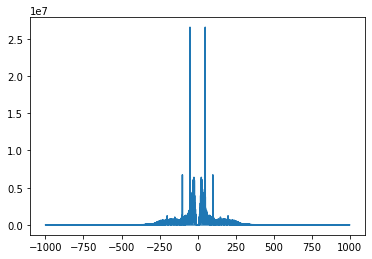

In [ ]:
wav2 = wave.open('/content/drive/MyDrive/Data Heart Beat/total data/sample_300.wav')
rate, data = wav.read('/content/drive/MyDrive/Data Heart Beat/total data/sample_300.wav')

##filtering Process 
fs = rate
T = wav2.getnframes()/wav2.getframerate()
N = nsamples = int(T * fs)
t = np.linspace(0, T, nsamples, endpoint=False)


lowcut = 20.0
highcut = 250.0

y = butter_bandpass(data,lowcut,highcut,fs)
#plt.plot(t,y)
#plt.show()

fft_out = fft(y)
%matplotlib inline
xf = fftfreq(N, 1 / fs)
plt.plot(xf, np.abs(fft_out))
plt.show()

50.06167763157895 49.95888157894737


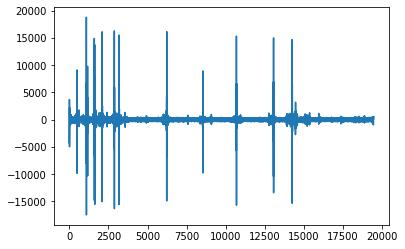

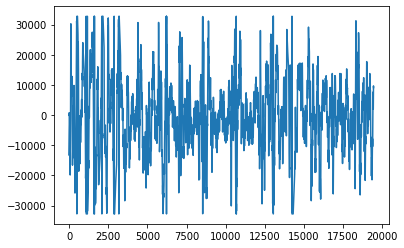

In [ ]:
rxf = xf
rate, data = wav.read('/content/drive/MyDrive/Data Heart Beat/total data/sample_300.wav')
rfft_out = rfft(y)
rfft_out2 = rfft(y)
freq = xf[np.argmax(np.abs(rfft_out))]
freq2 = xf[np.argsort(np.abs(rfft_out))[-2]]
print(freq , freq2)
# The maximum frequency is half the sample rate
points_per_freq = len(rxf) / (fs / 2)

# Our target frequency is freq Hz
target_idx = int(points_per_freq * freq)
rfft_out[-1000 : int(freq) -10] = 0
rfft_out[int(freq) + 10 : 1000] = 0
rfft_out2[-1000 : int(freq2) -5] = 0
rfft_out2[int(freq2) + 5 : 1000] = 0

new_sig1 = irfft(rfft_out)
new_sig2 = irfft(rfft_out2)
plt.plot(new_sig1)
plt.show()
plt.plot(data)
plt.show()
#plt.plot(xf, np.abs(fft_out))
#plt.show()


In [ ]:
import wave
wav = wave.open('/content/drive/MyDrive/Data Heart Beat/total data/sample_300.wav')
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  2000
Total samples (frames) =  19456
Duration =  9.728


In [ ]:
#rate, data = wav.read('/content/drive/MyDrive/Data Heart Beat/total data/sample_300.wav')
librosa.onset.onset_detect(y=y, sr=rate, units='time')

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


array([], dtype=float64)

In [ ]:
#rate, data = wav.read('/content/drive/MyDrive/Data Heart Beat/total data/sample_300.wav')

# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=new_sig1, sr=rate*3)
print(librosa.frames_to_time(onset_frames, sr=rate*3))


[0.68266667 1.10933333 1.19466667 1.536      1.87733333 2.21866667
 2.304      2.56      ]


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


In [ ]:
# use a pre-computed onset envelope
o_env = librosa.onset.onset_strength(y=new_sig1, sr=rate)
times = librosa.frames_to_time(np.arange(len(o_env)), sr=rate)
onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=rate*3)

# Detect events without backtracking
onset_raw = librosa.onset.onset_detect(onset_envelope=o_env, backtrack=False)
# Backtrack the events using the onset envelope
onset_bt = librosa.onset.onset_backtrack(onset_raw, o_env)
# Backtrack the events using the RMS values
rms = librosa.feature.rms(S=np.abs(librosa.stft(y=new_sig1)))
onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])
print(onset_bt)

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


[ 2  7 12 16 21 25]


NameError: ignored

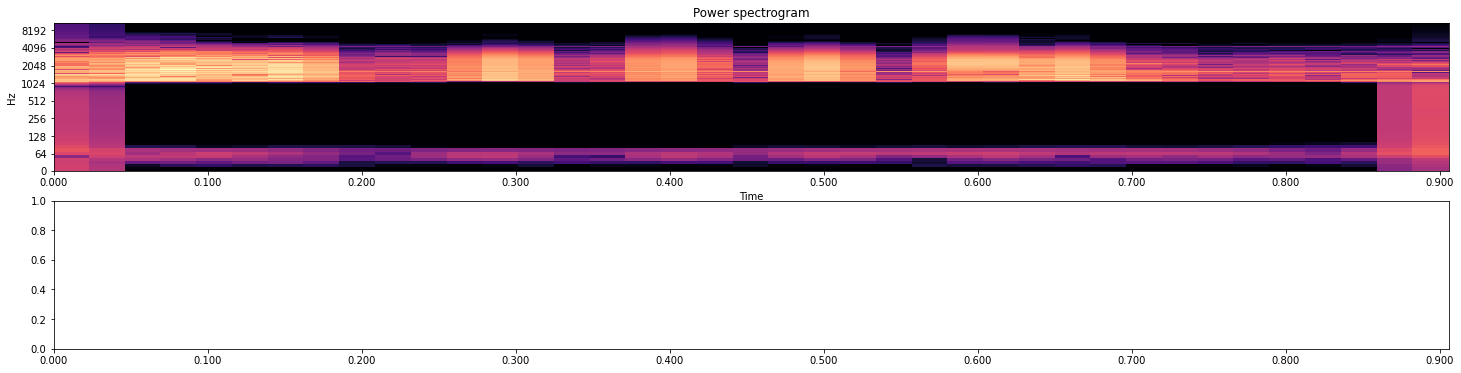

In [ ]:
import matplotlib.pyplot as plt

######################################################################
# visualize it
D = np.abs(librosa.stft(new_sig1))
plt.figure(figsize=(25, 6))
ax1 = plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),x_axis='time', y_axis='log')
plt.title('Power spectrogram')
plt.subplot(2, 1, 2, sharex=ax1)

plt.plot(times, o_env, label='Onset strength')
plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,linestyle='--', label='Onsets')
plt.vlines(times[onset_raw], 0, o_env.max(), label='Raw onsets',alpha=0.9)
plt.vlines(times[onset_bt], 0, o_env.max(), label='Backtracked', color='r',alpha=0.9)
plt.axis('tight')

plt.legend(frameon=True, framealpha=0.75)

In [ ]:
def onset(y,rate):


  # Get onset times from a signal
  onset_frames = librosa.onset.onset_detect(y=y, sr=rate*3)
  #print(librosa.frames_to_time(onset_frames, sr=rate*3))
  # use a pre-computed onset envelope
  o_env = librosa.onset.onset_strength(y=y, sr=rate)
  times = librosa.frames_to_time(np.arange(len(o_env)), sr=rate)
  onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=rate*3)

  # Detect events without backtracking
  onset_raw = librosa.onset.onset_detect(onset_envelope=o_env, backtrack=False)
  # Backtrack the events using the onset envelope
  onset_bt = librosa.onset.onset_backtrack(onset_raw, o_env)
  # Backtrack the events using the RMS values
  rms = librosa.feature.rms(S=np.abs(librosa.stft(y=y)))
  onset_bt_rms = librosa.onset.onset_backtrack(onset_raw, rms[0])
  return times,onset_bt
  

In [ ]:
def fft1(y,rate,N):
  xf = fftfreq(N, 1 / rate)
  rxf = xf
  rfft_out = rfft(y)
  rfft_out2 = rfft(y)
  freq = xf[np.argmax(np.abs(rfft_out))]
  freq2 = xf[np.argsort(np.abs(rfft_out))[-2]]
  #print(freq , freq2)
  # The maximum frequency is half the sample rate
  points_per_freq = len(rxf) / (fs / 2)

  # Our target frequency is freq Hz
  target_idx = int(points_per_freq * freq)
  rfft_out[-1000 : int(freq) -10] = 0
  rfft_out[int(freq) + 10 : 1000] = 0
  rfft_out2[-1000 : int(freq2) -5] = 0
  rfft_out2[int(freq2) + 5 : 1000] = 0

  new_sig1 = irfft(rfft_out)
  new_sig2 = irfft(rfft_out2)
  return new_sig1
  #plt.plot(xf, np.abs(fft_out))
  #plt.show()


In [ ]:
t_data_y = []

for j in range(50):
  t_data_x = []
  print("#########################"+str(j*10)+"######################################")
  data, sampling_rate = librosa.load('/content/drive/MyDrive/Data Heart Beat/total data/sample_'+str(j*10)+'.wav')
  wav = wave.open('/content/drive/MyDrive/Data Heart Beat/total data/sample_'+str(j*10)+'.wav')
  data_BPF = butter_bandpass(data,lowcut,highcut,sampling_rate)
  N = wav.getnframes()
  data_FFT = fft1(data_BPF,sampling_rate,N)
  times , onset_bt = onset(data_FFT,sampling_rate)
  for i in range(0, len(onset_bt) ):
    try: 
      temp_data = data_BPF[int(times[onset_bt[i]]*sampling_rate ):int(times[onset_bt[i+1]]*sampling_rate) ]
      t_data_x.append(temp_data)
    except:
      pass
  t_data_x = pad_sequences(t_data_x, maxlen=20000, dtype='float', padding='post', truncating='post', value=0.)
  #t_data_x = t_data_x / np.max(t_data_x)
  y_pred = classifier.predict(t_data_x)
  print(y_pred)
  data_y = np.concatenate((data_y, y_pred))
  data_x = np.concatenate((data_x, t_data_x))

#t_data_x.append(temp_data)
#temp_data = data[int(times[onset_bt[4]]*sampling_rate ):int(times[onset_bt[5]]*sampling_rate )]
#t_data_x.append(temp_data)


#t_data_x = t_data_x[:,np.newaxis]
print(t_data_x.shape)


#########################0######################################


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


90
#########################10######################################
90
#########################20######################################
90
#########################30######################################
90
#########################40######################################
90
#########################50######################################
90
#########################60######################################
90
#########################70######################################
90
#########################80######################################
90
#########################90######################################
90
#########################100######################################
90
#########################110######################################
90
#########################120######################################
90
#########################130######################################
90
#########################140######################################
90
#########################1

In [ ]:
data_x = data_x[:,:,np.newaxis]

print(data_x.shape)
print(data_y.shape)

(369, 20000, 1, 1)
(369,)


In [ ]:
from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPool1D
from keras.models import Sequential
model = Sequential()

model.add(InputLayer(input_shape=data_x.shape[1:]))

model.add(Conv1D(filters=50, kernel_size=10, activation='relu'))
model.add(MaxPool1D(strides=8))
model.add(Conv1D(filters=50, kernel_size=10, activation='relu'))
model.add(MaxPool1D(strides=8))
model.add(Flatten())
model.add(Dense(units=1, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ValueError: ignored

In [ ]:
model.fit(data_x, data_y, batch_size=32, epochs=3)


Epoch 1/3
60/60 [==============================] - 37s 607ms/step - loss: 0.5762 - accuracy: 0.2452
Epoch 2/3
60/60 [==============================] - 36s 608ms/step - loss: 0.5414 - accuracy: 0.2452
Epoch 3/3
60/60 [==============================] - 36s 604ms/step - loss: 0.5142 - accuracy: 0.2452
